In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss functions
def mean_squared_error(y_true, y_pred):
    return np.mean(np.sum((y_true - y_pred) ** 2, axis=1))

def mean_squared_error_derivative(y_true, y_pred):
    return y_pred - y_true

def cross_entropy(y_true, y_pred):
    # Add small epsilon to avoid log(0)
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def cross_entropy_derivative(y_true, y_pred):
    # Add small epsilon to avoid division by zero
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -y_true / y_pred

class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, loss_function='mse', batch_size=None, dropout_rate=0.0):
        """
        Initialize neural network with specified architecture
        
        Parameters:
            layer_sizes: List of integers specifying the number of neurons in each layer
                        (including input and output layers)
            learning_rate: Learning rate for gradient descent
            loss_function: 'mse' for Mean Squared Error or 'cross_entropy' for Cross Entropy Loss
            batch_size: Size of mini-batches (None for full batch, 1 for stochastic)
            dropout_rate: Probability of dropping neurons during training (0.0 to 0.5 recommended)
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.num_layers = len(layer_sizes)
        self.loss_function = loss_function
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        for i in range(len(layer_sizes) - 1):
            # Xavier/Glorot initialization for better convergence
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
        
        # Storage for activations and z values (pre-activations)
        self.activations = []
        self.z_values = []
        
        # Storage for dropout masks
        self.dropout_masks = []
        
        # For recording training history
        self.train_loss_history = []
        self.val_loss_history = []
        
    def forward(self, X, training=True):
        """
        Forward pass through the network
        
        Parameters:
            X: Input data
            training: Boolean flag for training mode (enables dropout)
            
        Returns:
            Output predictions
        """
        self.activations = [X]  # Input layer
        self.z_values = []
        self.dropout_masks = []
        
        # Process all hidden layers
        for i in range(self.num_layers - 2):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            
            # Use ReLU for hidden layers
            a = relu(z)
            
            # Apply dropout during training
            if training and self.dropout_rate > 0:
                mask = np.random.binomial(1, 1 - self.dropout_rate, size=a.shape) / (1 - self.dropout_rate)
                a *= mask
                self.dropout_masks.append(mask)
            else:
                self.dropout_masks.append(None)
                
            self.activations.append(a)
        
        # Output layer
        z_out = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(z_out)
        
        # Use sigmoid for binary classification or softmax for multi-class
        a_out = sigmoid(z_out)
        self.activations.append(a_out)
        
        return self.activations[-1]
    
    def compute_loss(self, y_true, y_pred):
        """Calculate loss based on selected loss function"""
        if self.loss_function == 'mse':
            return mean_squared_error(y_true, y_pred)
        elif self.loss_function == 'cross_entropy':
            return cross_entropy(y_true, y_pred)
        else:
            raise ValueError("Unsupported loss function")
    
    def compute_loss_derivative(self, y_true, y_pred):
        """Calculate derivative of loss function"""
        if self.loss_function == 'mse':
            return mean_squared_error_derivative(y_true, y_pred)
        elif self.loss_function == 'cross_entropy':
            return cross_entropy_derivative(y_true, y_pred)
        else:
            raise ValueError("Unsupported loss function")
    
    def backward(self, y_true):
        """
        Backward pass - backpropagation
        
        Parameters:
            y_true: True labels
            
        Returns:
            Loss value
        """
        m = y_true.shape[0]  # Number of examples
        y_pred = self.activations[-1]
        
        # Calculate loss
        loss = self.compute_loss(y_true, y_pred)
        
        # Initialize gradients
        dw = [0] * len(self.weights)
        db = [0] * len(self.biases)
        
        # Output layer error
        delta = self.compute_loss_derivative(y_true, y_pred)
        if self.loss_function == 'mse':
            delta = delta * sigmoid_derivative(y_pred)
        
        # Calculate gradients for output layer
        dw[-1] = np.dot(self.activations[-2].T, delta) / m
        db[-1] = np.sum(delta, axis=0, keepdims=True) / m
        
        # Backpropagate through hidden layers
        for l in range(2, self.num_layers):
            delta = np.dot(delta, self.weights[-l+1].T)
            
            # Apply dropout mask if applicable
            if self.dropout_masks[-l+1] is not None:
                delta *= self.dropout_masks[-l+1]
            
            delta = delta * relu_derivative(self.activations[-l])
            
            dw[-l] = np.dot(self.activations[-l-1].T, delta) / m
            db[-l] = np.sum(delta, axis=0, keepdims=True) / m
        
        # Store gradients
        self.dw = dw
        self.db = db
        
        return loss
    
    def update_weights(self):
        """Update weights using gradient descent"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.dw[i]
            self.biases[i] -= self.learning_rate * self.db[i]
    
    def train_iteration(self, X, y):
        """One iteration of training for the whole dataset or mini-batch"""
        self.forward(X, training=True)
        loss = self.backward(y)
        self.update_weights()
        return loss
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, 
              early_stopping=True, patience=10, verbose=True):
        """
        Train the model
        
        Parameters:
            X_train: Training features
            y_train: Training labels
            X_val: Validation features
            y_val: Validation labels
            epochs: Maximum number of epochs
            early_stopping: Whether to use early stopping
            patience: Number of epochs to wait for improvement before stopping
            verbose: Whether to print progress
            
        Returns:
            Best epoch and loss histories
        """
        n_samples = X_train.shape[0]
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement = 0
        
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Process in batches
            if self.batch_size is None:  # Full batch
                loss = self.train_iteration(X_shuffled, y_shuffled)
            else:  # Mini-batch or stochastic
                loss = 0
                for i in range(0, n_samples, self.batch_size):
                    X_batch = X_shuffled[i:i+self.batch_size]
                    y_batch = y_shuffled[i:i+self.batch_size]
                    batch_loss = self.train_iteration(X_batch, y_batch)
                    loss += batch_loss * len(X_batch) / n_samples
            
            # Record training loss
            self.train_loss_history.append(loss)
            
            # Validate if validation data is provided
            if X_val is not None and y_val is not None:
                val_predictions = self.forward(X_val, training=False)
                val_loss = self.compute_loss(y_val, val_predictions)
                self.val_loss_history.append(val_loss)
                
                # Check for early stopping
                if early_stopping:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_epoch = epoch
                        no_improvement = 0
                    else:
                        no_improvement += 1
                        
                    if no_improvement >= patience:
                        if verbose:
                            print(f"Early stopping at epoch {epoch}, best epoch: {best_epoch}")
                        break
                
                if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                    print(f"Epoch {epoch}: Train Loss = {loss:.6f}, Val Loss = {val_loss:.6f}")
            else:
                if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                    print(f"Epoch {epoch}: Train Loss = {loss:.6f}")
        
        return best_epoch if early_stopping else epochs - 1
    
    def predict(self, X):
        """Make predictions for test data"""
        return self.forward(X, training=False)
    
    def evaluate(self, X, y):
        """Evaluate model performance"""
        predictions = self.predict(X)
        loss = self.compute_loss(y, predictions)
        
        # For binary classification
        if y.shape[1] == 1:
            predicted_classes = (predictions > 0.5).astype(int)
            accuracy = np.mean(predicted_classes == y)
        # For multi-class classification
        else:
            predicted_classes = np.argmax(predictions, axis=1)
            true_classes = np.argmax(y, axis=1)
            accuracy = np.mean(predicted_classes == true_classes)
            
        return loss, accuracy
    
    def plot_loss_curves(self):
        """Plot training and validation loss curves"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_loss_history, label='Training Loss')
        if self.val_loss_history:
            plt.plot(self.val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Curves ({self.loss_function.upper()})')
        plt.grid(True)
        plt.show()

# Load and preprocess obesity dataset
def load_obesity_data(file_path="obesity_data.csv"):
    """
    Load and preprocess the obesity dataset
    
    Returns:
        X_train, X_test, y_train, y_test: Split datasets
    """
    try:
        # Load data
        df = pd.read_csv(file_path)
        
        # Identify features and target variable
        X = df.drop(['NObeyesdad'], axis=1)  # Assuming 'NObeyesdad' is the target column
        y = df['NObeyesdad']
        
        # Encode categorical variables
        X = pd.get_dummies(X)
        
        # Encode target (assuming it's categorical)
        y_encoded = pd.get_dummies(y).values
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=0.2, random_state=42)
        
        print(f"Data loaded successfully. Features shape: {X.shape}, Target classes: {y.nunique()}")
        
        return X_train, X_test, y_train, y_test, X.shape[1], y_encoded.shape[1]
    
    except FileNotFoundError:
        print(f"Error: Could not find the file {file_path}")
        # Create dummy data for demonstration purposes
        print("Creating dummy data for demonstration...")
        X = np.random.rand(500, 10)
        y = np.zeros((500, 3))
        for i in range(500):
            y[i, np.random.randint(0, 3)] = 1
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)
        
        return X_train, X_test, y_train, y_test, 10, 3

def main():
    # Load and preprocess data
    X_train, X_test, y_train, y_test, input_size, output_size = load_obesity_data()
    
    print("\n--- DATASET INFO ---")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Input features: {input_size}")
    print(f"Output classes: {output_size}")
    
    # Create validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)
    
    # Define parameters
    loss_functions = ['mse', 'cross_entropy']
    batch_types = ['full', 'mini-batch', 'stochastic']
    
    results = []
    
    # Model configurations
    models = [
        {
            "name": "N1 (3 Hidden Layers)",
            "layers": [input_size, 128, 64, 32, output_size]
        },
        {
            "name": "N2 (4 Hidden Layers)",
            "layers": [input_size, 128, 64, 32, 16, output_size]
        }
    ]
    
    # Train and evaluate all configurations
    for model_config in models:
        for loss_fn in loss_functions:
            for batch_type in batch_types:
                
                # Set batch size
                if batch_type == 'full':
                    batch_size = None
                elif batch_type == 'mini-batch':
                    batch_size = 40  # As requested
                else:  # Stochastic
                    batch_size = 1
                
                # Test with and without dropout
                for dropout in [0.0, 0.2]:
                    model_name = f"{model_config['name']} - {loss_fn} - {batch_type}"
                    if dropout > 0:
                        model_name += f" - dropout({dropout})"
                    
                    print(f"\n\n{'='*50}")
                    print(f"Training {model_name}")
                    print(f"{'='*50}")
                    
                    # Create and train model
                    nn = NeuralNetwork(
                        layer_sizes=model_config['layers'],
                        learning_rate=0.01,
                        loss_function=loss_fn,
                        batch_size=batch_size,
                        dropout_rate=dropout
                    )
                    
                    # Train with early stopping
                    best_epoch = nn.train(
                        X_train, y_train, 
                        X_val, y_val, 
                        epochs=200,
                        early_stopping=True,
                        patience=10,
                        verbose=True
                    )
                    
                    # Evaluate on test set
                    test_loss, test_accuracy = nn.evaluate(X_test, y_test)
                    
                    # Store results
                    results.append({
                        'model': model_name,
                        'best_epoch': best_epoch,
                        'test_loss': test_loss,
                        'test_accuracy': test_accuracy
                    })
                    
                    print(f"\nTest Loss: {test_loss:.6f}")
                    print(f"Test Accuracy: {test_accuracy:.2%}")
                    print(f"Best Epoch: {best_epoch}")
                    
                    # Plot loss curves
                    nn.plot_loss_curves()
    
    # Print summary of results
    print("\n\n--- SUMMARY OF RESULTS ---")
    print(f"{'Model':<50} | {'Best Epoch':<10} | {'Test Loss':<10} | {'Test Accuracy':<15}")
    print('-' * 90)
    
    for result in results:
        print(f"{result['model']:<50} | {result['best_epoch']:<10} | {result['test_loss']:<10.6f} | {result['test_accuracy']:<15.2%}")

if __name__ == "__main__":
    main()

KeyError: "['NObeyesdad'] not found in axis"

Attempting to load data from obesity_data.csv...
Available columns in the dataset:
['Age', 'Gender', 'Height', 'Weight', 'BMI', 'PhysicalActivityLevel', 'ObesityCategory']
Assuming the last column 'ObesityCategory' is the target variable.
Target variable unique values: ['Normal weight', 'Obese', 'Overweight', 'Underweight']
Number of classes: 4
Encoding categorical features: ['Gender']
Encoding categorical target variable...
Scaling features...
Splitting data into train/test sets...
Data loaded successfully. Features shape: (1000, 7), Target shape: (1000, 4)

--- DATASET INFO ---
Training samples: 800
Test samples: 200
Input features: 7
Output classes: 4


Training N1 (3 Hidden Layers) - mse - full
Epoch 0: Train Loss = 0.766985, Val Loss = 0.774525
Epoch 10: Train Loss = 0.744120, Val Loss = 0.751189
Epoch 20: Train Loss = 0.725917, Val Loss = 0.732286
Epoch 30: Train Loss = 0.710234, Val Loss = 0.716057
Epoch 40: Train Loss = 0.695915, Val Loss = 0.701455
Epoch 50: Train Loss = 0.682

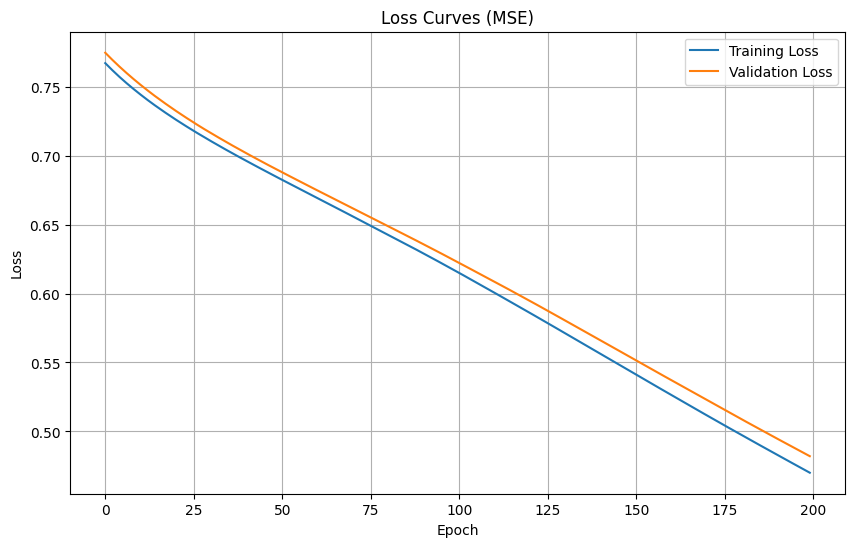



Training N1 (3 Hidden Layers) - mse - full - dropout(0.2)
Epoch 0: Train Loss = 0.775256, Val Loss = 0.769979
Epoch 10: Train Loss = 0.762479, Val Loss = 0.760770
Epoch 20: Train Loss = 0.751996, Val Loss = 0.752408
Epoch 30: Train Loss = 0.750330, Val Loss = 0.744721
Epoch 40: Train Loss = 0.744773, Val Loss = 0.737212
Epoch 50: Train Loss = 0.739053, Val Loss = 0.729861
Epoch 60: Train Loss = 0.730809, Val Loss = 0.722749
Epoch 70: Train Loss = 0.726603, Val Loss = 0.715548
Epoch 80: Train Loss = 0.722059, Val Loss = 0.708505
Epoch 90: Train Loss = 0.715264, Val Loss = 0.701261
Epoch 100: Train Loss = 0.704868, Val Loss = 0.693983
Epoch 110: Train Loss = 0.697710, Val Loss = 0.686712
Epoch 120: Train Loss = 0.697262, Val Loss = 0.679210
Epoch 130: Train Loss = 0.684415, Val Loss = 0.671518
Epoch 140: Train Loss = 0.675014, Val Loss = 0.663701
Epoch 150: Train Loss = 0.665907, Val Loss = 0.655484
Epoch 160: Train Loss = 0.663683, Val Loss = 0.646927
Epoch 170: Train Loss = 0.662393,

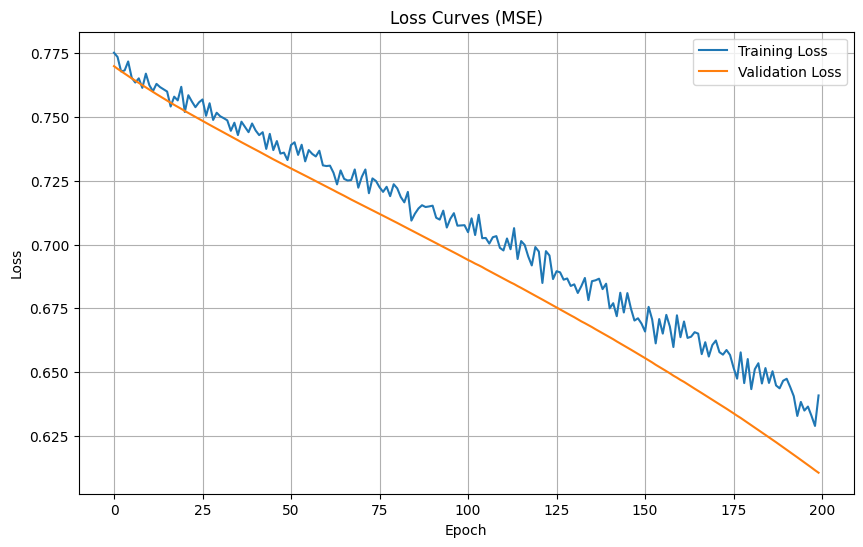



Training N1 (3 Hidden Layers) - mse - mini-batch
Epoch 0: Train Loss = 0.751885, Val Loss = 0.739542
Epoch 10: Train Loss = 0.619413, Val Loss = 0.615528
Epoch 20: Train Loss = 0.453176, Val Loss = 0.457354
Epoch 30: Train Loss = 0.308720, Val Loss = 0.325515
Epoch 40: Train Loss = 0.206955, Val Loss = 0.234480
Epoch 50: Train Loss = 0.144881, Val Loss = 0.178287
Epoch 60: Train Loss = 0.110029, Val Loss = 0.145322
Epoch 70: Train Loss = 0.088051, Val Loss = 0.123486
Epoch 80: Train Loss = 0.073264, Val Loss = 0.110527
Epoch 90: Train Loss = 0.063369, Val Loss = 0.102532
Epoch 100: Train Loss = 0.055628, Val Loss = 0.093710
Epoch 110: Train Loss = 0.049497, Val Loss = 0.088596
Epoch 120: Train Loss = 0.044376, Val Loss = 0.083771
Epoch 130: Train Loss = 0.040007, Val Loss = 0.080364
Epoch 140: Train Loss = 0.036628, Val Loss = 0.082787
Epoch 150: Train Loss = 0.034443, Val Loss = 0.079070
Epoch 160: Train Loss = 0.030966, Val Loss = 0.078446
Early stopping at epoch 168, best epoch: 1

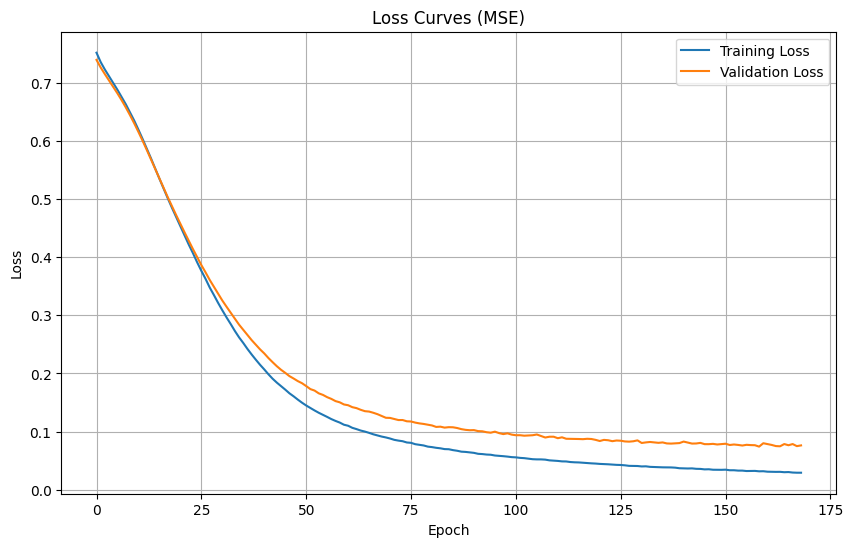



Training N1 (3 Hidden Layers) - mse - mini-batch - dropout(0.2)
Epoch 0: Train Loss = 0.735686, Val Loss = 0.726337
Epoch 10: Train Loss = 0.567446, Val Loss = 0.531198
Epoch 20: Train Loss = 0.440277, Val Loss = 0.387875
Epoch 30: Train Loss = 0.367387, Val Loss = 0.287820
Epoch 40: Train Loss = 0.293766, Val Loss = 0.219189
Epoch 50: Train Loss = 0.265119, Val Loss = 0.181053
Epoch 60: Train Loss = 0.260647, Val Loss = 0.150004
Epoch 70: Train Loss = 0.214754, Val Loss = 0.135852
Epoch 80: Train Loss = 0.200849, Val Loss = 0.124895
Epoch 90: Train Loss = 0.181859, Val Loss = 0.114005
Epoch 100: Train Loss = 0.151337, Val Loss = 0.102841
Epoch 110: Train Loss = 0.158820, Val Loss = 0.099087
Epoch 120: Train Loss = 0.160053, Val Loss = 0.092172
Epoch 130: Train Loss = 0.146263, Val Loss = 0.088782
Epoch 140: Train Loss = 0.132935, Val Loss = 0.086168
Epoch 150: Train Loss = 0.138346, Val Loss = 0.081168
Epoch 160: Train Loss = 0.130777, Val Loss = 0.079787
Epoch 170: Train Loss = 0.0

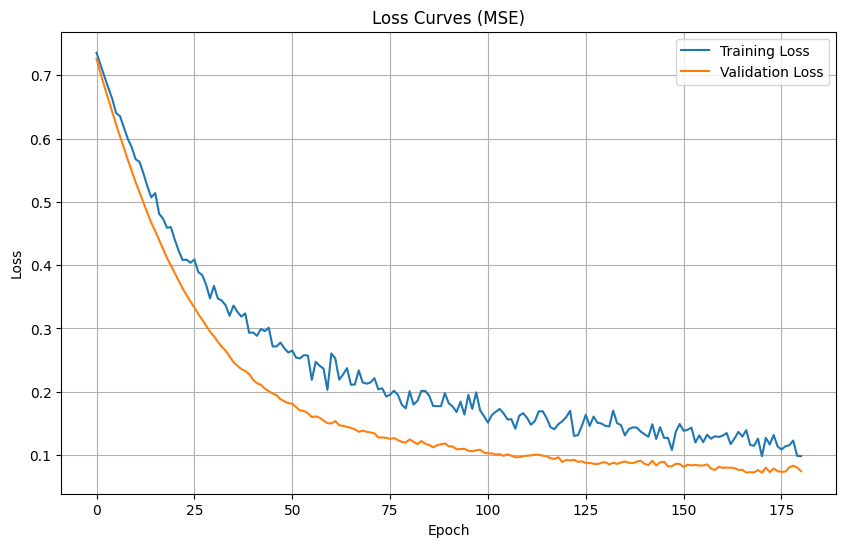



Training N1 (3 Hidden Layers) - mse - stochastic
Epoch 0: Train Loss = 0.422628, Val Loss = 0.227853
Epoch 10: Train Loss = 0.076070, Val Loss = 0.113252
Epoch 20: Train Loss = 0.059842, Val Loss = 0.133377
Epoch 30: Train Loss = 0.038252, Val Loss = 0.137693
Epoch 40: Train Loss = 0.048278, Val Loss = 0.168594
Early stopping at epoch 41, best epoch: 31

Test Loss: 0.159474
Test Accuracy: 90.50%
Best Epoch: 31


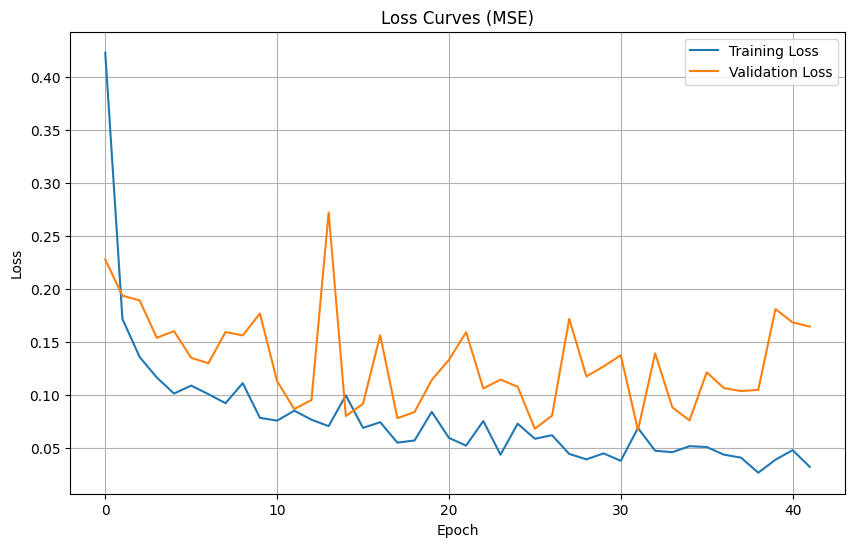



Training N1 (3 Hidden Layers) - mse - stochastic - dropout(0.2)
Epoch 0: Train Loss = 0.563000, Val Loss = 0.345509
Epoch 10: Train Loss = 0.137691, Val Loss = 0.089484
Early stopping at epoch 20, best epoch: 10

Test Loss: 0.081495
Test Accuracy: 94.50%
Best Epoch: 10


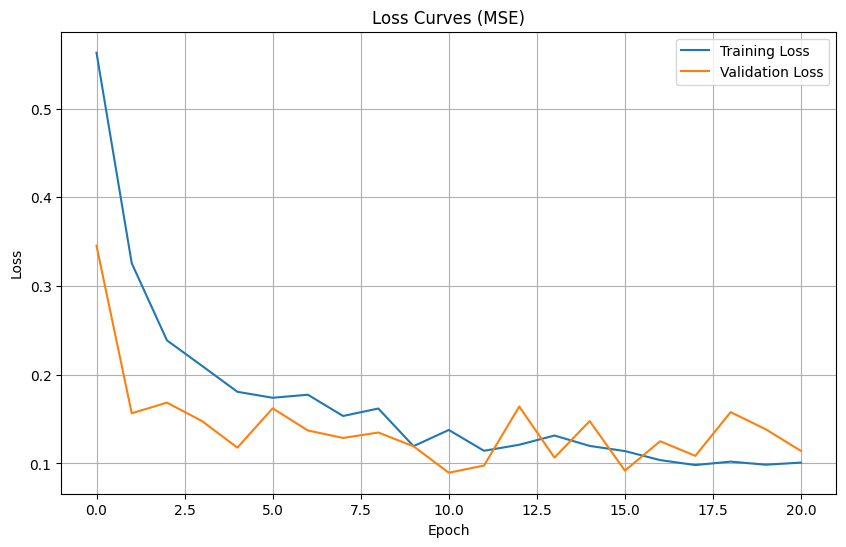



Training N1 (3 Hidden Layers) - cross_entropy - full


TypeError: The numpy boolean negative, the `-` operator, is not supported, use the `~` operator or the logical_not function instead.

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss functions
def mean_squared_error(y_true, y_pred):
    return np.mean(np.sum((y_true - y_pred) ** 2, axis=1))

def mean_squared_error_derivative(y_true, y_pred):
    return y_pred - y_true

def cross_entropy(y_true, y_pred):
    # Add small epsilon to avoid log(0)
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def cross_entropy_derivative(y_true, y_pred):
    # Add small epsilon to avoid division by zero
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -y_true / y_pred

class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, loss_function='mse', batch_size=None, dropout_rate=0.0):
        """
        Initialize neural network with specified architecture
        
        Parameters:
            layer_sizes: List of integers specifying the number of neurons in each layer
                        (including input and output layers)
            learning_rate: Learning rate for gradient descent
            loss_function: 'mse' for Mean Squared Error or 'cross_entropy' for Cross Entropy Loss
            batch_size: Size of mini-batches (None for full batch, 1 for stochastic)
            dropout_rate: Probability of dropping neurons during training (0.0 to 0.5 recommended)
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.num_layers = len(layer_sizes)
        self.loss_function = loss_function
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        for i in range(len(layer_sizes) - 1):
            # Xavier/Glorot initialization for better convergence
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
        
        # Storage for activations and z values (pre-activations)
        self.activations = []
        self.z_values = []
        
        # Storage for dropout masks
        self.dropout_masks = []
        
        # For recording training history
        self.train_loss_history = []
        self.val_loss_history = []
        
    def forward(self, X, training=True):
        """
        Forward pass through the network
        
        Parameters:
            X: Input data
            training: Boolean flag for training mode (enables dropout)
            
        Returns:
            Output predictions
        """
        self.activations = [X]  # Input layer
        self.z_values = []
        self.dropout_masks = []
        
        # Process all hidden layers
        for i in range(self.num_layers - 2):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            
            # Use ReLU for hidden layers
            a = relu(z)
            
            # Apply dropout during training
            if training and self.dropout_rate > 0:
                mask = np.random.binomial(1, 1 - self.dropout_rate, size=a.shape) / (1 - self.dropout_rate)
                a *= mask
                self.dropout_masks.append(mask)
            else:
                self.dropout_masks.append(None)
                
            self.activations.append(a)
        
        # Output layer
        z_out = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(z_out)
        
        # Use sigmoid for binary classification or softmax for multi-class
        if self.layer_sizes[-1] > 1:  # Multi-class classification
            a_out = softmax(z_out)
        else:  # Binary classification
            a_out = sigmoid(z_out)
            
        self.activations.append(a_out)
        
        return self.activations[-1]
    
    def compute_loss(self, y_true, y_pred):
        """Calculate loss based on selected loss function"""
        if self.loss_function == 'mse':
            return mean_squared_error(y_true, y_pred)
        elif self.loss_function == 'cross_entropy':
            return cross_entropy(y_true, y_pred)
        else:
            raise ValueError("Unsupported loss function")
    
    def compute_loss_derivative(self, y_true, y_pred):
        """Calculate derivative of loss function"""
        if self.loss_function == 'mse':
            return mean_squared_error_derivative(y_true, y_pred)
        elif self.loss_function == 'cross_entropy':
            return cross_entropy_derivative(y_true, y_pred)
        else:
            raise ValueError("Unsupported loss function")
    
    def backward(self, y_true):
        """
        Backward pass - backpropagation
        
        Parameters:
            y_true: True labels
            
        Returns:
            Loss value
        """
        m = y_true.shape[0]  # Number of examples
        y_pred = self.activations[-1]
        
        # Calculate loss
        loss = self.compute_loss(y_true, y_pred)
        
        # Initialize gradients
        dw = [0] * len(self.weights)
        db = [0] * len(self.biases)
        
        # Output layer error
        delta = self.compute_loss_derivative(y_true, y_pred)
        if self.loss_function == 'mse':
            if self.layer_sizes[-1] > 1:  # Multi-class with softmax
                pass  # Delta already calculated correctly for softmax with MSE
            else:  # Binary with sigmoid
                delta = delta * sigmoid_derivative(y_pred)
        
        # Calculate gradients for output layer
        dw[-1] = np.dot(self.activations[-2].T, delta) / m
        db[-1] = np.sum(delta, axis=0, keepdims=True) / m
        
        # Backpropagate through hidden layers
        for l in range(2, self.num_layers):
            delta = np.dot(delta, self.weights[-l+1].T)
            
            # Apply dropout mask if applicable
            if self.dropout_masks[-l+1] is not None:
                delta *= self.dropout_masks[-l+1]
            
            delta = delta * relu_derivative(self.activations[-l])
            
            dw[-l] = np.dot(self.activations[-l-1].T, delta) / m
            db[-l] = np.sum(delta, axis=0, keepdims=True) / m
        
        # Store gradients
        self.dw = dw
        self.db = db
        
        return loss
    
    def update_weights(self):
        """Update weights using gradient descent"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.dw[i]
            self.biases[i] -= self.learning_rate * self.db[i]
    
    def train_iteration(self, X, y):
        """One iteration of training for the whole dataset or mini-batch"""
        self.forward(X, training=True)
        loss = self.backward(y)
        self.update_weights()
        return loss
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, 
              early_stopping=True, patience=10, verbose=True):
        """
        Train the model
        
        Parameters:
            X_train: Training features
            y_train: Training labels
            X_val: Validation features
            y_val: Validation labels
            epochs: Maximum number of epochs
            early_stopping: Whether to use early stopping
            patience: Number of epochs to wait for improvement before stopping
            verbose: Whether to print progress
            
        Returns:
            Best epoch and loss histories
        """
        n_samples = X_train.shape[0]
        best_val_loss = float('inf')
        best_epoch = 0
        no_improvement = 0
        
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(n_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            # Process in batches
            if self.batch_size is None:  # Full batch
                loss = self.train_iteration(X_shuffled, y_shuffled)
            else:  # Mini-batch or stochastic
                loss = 0
                for i in range(0, n_samples, self.batch_size):
                    X_batch = X_shuffled[i:i+self.batch_size]
                    y_batch = y_shuffled[i:i+self.batch_size]
                    batch_loss = self.train_iteration(X_batch, y_batch)
                    loss += batch_loss * len(X_batch) / n_samples
            
            # Record training loss
            self.train_loss_history.append(loss)
            
            # Validate if validation data is provided
            if X_val is not None and y_val is not None:
                val_predictions = self.forward(X_val, training=False)
                val_loss = self.compute_loss(y_val, val_predictions)
                self.val_loss_history.append(val_loss)
                
                # Check for early stopping
                if early_stopping:
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_epoch = epoch
                        no_improvement = 0
                    else:
                        no_improvement += 1
                        
                    if no_improvement >= patience:
                        if verbose:
                            print(f"Early stopping at epoch {epoch}, best epoch: {best_epoch}")
                        break
                
                if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                    print(f"Epoch {epoch}: Train Loss = {loss:.6f}, Val Loss = {val_loss:.6f}")
            else:
                if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                    print(f"Epoch {epoch}: Train Loss = {loss:.6f}")
        
        return best_epoch if early_stopping else epochs - 1
    
    def predict(self, X):
        """Make predictions for test data"""
        return self.forward(X, training=False)
    
    def evaluate(self, X, y):
        """Evaluate model performance"""
        predictions = self.predict(X)
        loss = self.compute_loss(y, predictions)
        
        # For binary classification
        if y.shape[1] == 1:
            predicted_classes = (predictions > 0.5).astype(int)
            accuracy = np.mean(predicted_classes == y)
        # For multi-class classification
        else:
            predicted_classes = np.argmax(predictions, axis=1)
            true_classes = np.argmax(y, axis=1)
            accuracy = np.mean(predicted_classes == true_classes)
            
        return loss, accuracy
    
    def plot_loss_curves(self):
        """Plot training and validation loss curves"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_loss_history, label='Training Loss')
        if self.val_loss_history:
            plt.plot(self.val_loss_history, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Loss Curves ({self.loss_function.upper()})')
        plt.grid(True)
        plt.show()

# Load and preprocess obesity dataset
def load_obesity_data(file_path='obesity_data.csv'):
    """
    Load and preprocess the obesity dataset
    
    Returns:
        X_train, X_test, y_train, y_test: Split datasets
    """
    try:
        # Load data
        print(f"Attempting to load data from {file_path}...")
        df = pd.read_csv(file_path)
        
        # Print column names to help identify the target column
        print("Available columns in the dataset:")
        print(df.columns.tolist())
        
        # Try to identify the target column - often it's the last column
        # or has a name like 'target', 'class', 'label', etc.
        potential_target_columns = ['class', 'target', 'label', 'category', 'NObeyesdad', 'obesity', 
                                  'result', 'output', 'classification']
        
        target_column = None
        for col in potential_target_columns:
            if col in df.columns:
                target_column = col
                break
                
        if target_column is None:
            # If no common target column name is found, assume the last column is the target
            target_column = df.columns[-1]
            print(f"Assuming the last column '{target_column}' is the target variable.")
        else:
            print(f"Identified '{target_column}' as the target variable.")
        
        # Split features and target
        X = df.drop([target_column], axis=1)
        y = df[target_column]
        
        print(f"Target variable unique values: {y.unique().tolist()}")
        print(f"Number of classes: {y.nunique()}")
        
        # Handle categorical features
        categorical_columns = X.select_dtypes(include=['object', 'category']).columns
        if not categorical_columns.empty:
            print(f"Encoding categorical features: {categorical_columns.tolist()}")
            X = pd.get_dummies(X)
        
        # Encode target (assuming it's categorical)
        if y.dtype == 'object' or y.dtype.name == 'category':
            print("Encoding categorical target variable...")
            y_encoded = pd.get_dummies(y).values
        else:
            # If target is numeric and binary (0/1), convert to one-hot
            if y.nunique() == 2 and set(y.unique()).issubset({0, 1}):
                y_encoded = y.values.reshape(-1, 1)
            # If target is numeric and multi-class, convert to one-hot
            else:
                print("Converting numeric multi-class target to one-hot encoding...")
                y_encoded = np.zeros((len(y), y.nunique()))
                for i, val in enumerate(y):
                    y_encoded[i, val] = 1
        
        # Scale features
        print("Scaling features...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split data
        print("Splitting data into train/test sets...")
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=0.2, random_state=42)
        
        print(f"Data loaded successfully. Features shape: {X.shape}, Target shape: {y_encoded.shape}")
        
        return X_train, X_test, y_train, y_test, X.shape[1], y_encoded.shape[1]
    
    except FileNotFoundError:
        print(f"Error: Could not find the file {file_path}")
        # Create dummy data for demonstration purposes
        print("Creating dummy data for demonstration...")
        X = np.random.rand(500, 10)
        y = np.zeros((500, 3))
        for i in range(500):
            y[i, np.random.randint(0, 3)] = 1
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)
        
        return X_train, X_test, y_train, y_test, 10, 3
    except Exception as e:
        print(f"An error occurred while loading the data: {str(e)}")
        # Create dummy data for demonstration purposes
        print("Creating dummy data for demonstration...")
        X = np.random.rand(500, 10)
        y = np.zeros((500, 3))
        for i in range(500):
            y[i, np.random.randint(0, 3)] = 1
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)
        
        return X_train, X_test, y_train, y_test, 10, 3

def main():
    # Load and preprocess data
    X_train, X_test, y_train, y_test, input_size, output_size = load_obesity_data()
    
    print("\n--- DATASET INFO ---")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Input features: {input_size}")
    print(f"Output classes: {output_size}")
    
    # Create validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)
    
    # Define parameters
    loss_functions = ['mse', 'cross_entropy']
    batch_types = ['full', 'mini-batch', 'stochastic']
    
    results = []
    
    # Model configurations
    models = [
        {
            "name": "N1 (3 Hidden Layers)",
            "layers": [input_size, 128, 64, 32, output_size]
        },
        {
            "name": "N2 (4 Hidden Layers)",
            "layers": [input_size, 128, 64, 32, 16, output_size]
        }
    ]
    
    # Train and evaluate all configurations
    for model_config in models:
        for loss_fn in loss_functions:
            for batch_type in batch_types:
                
                # Set batch size
                if batch_type == 'full':
                    batch_size = None
                elif batch_type == 'mini-batch':
                    batch_size = 40  # As requested
                else:  # Stochastic
                    batch_size = 1
                
                # Test with and without dropout
                for dropout in [0.0, 0.2]:
                    model_name = f"{model_config['name']} - {loss_fn} - {batch_type}"
                    if dropout > 0:
                        model_name += f" - dropout({dropout})"
                    
                    print(f"\n\n{'='*50}")
                    print(f"Training {model_name}")
                    print(f"{'='*50}")
                    
                    # Create and train model
                    nn = NeuralNetwork(
                        layer_sizes=model_config['layers'],
                        learning_rate=0.01,
                        loss_function=loss_fn,
                        batch_size=batch_size,
                        dropout_rate=dropout
                    )
                    
                    # Train with early stopping
                    best_epoch = nn.train(
                        X_train, y_train, 
                        X_val, y_val, 
                        epochs=200,
                        early_stopping=True,
                        patience=10,
                        verbose=True
                    )
                    
                    # Evaluate on test set
                    test_loss, test_accuracy = nn.evaluate(X_test, y_test)
                    
                    # Store results
                    results.append({
                        'model': model_name,
                        'best_epoch': best_epoch,
                        'test_loss': test_loss,
                        'test_accuracy': test_accuracy
                    })
                    
                    print(f"\nTest Loss: {test_loss:.6f}")
                    print(f"Test Accuracy: {test_accuracy:.2%}")
                    print(f"Best Epoch: {best_epoch}")
                    
                    # Plot loss curves
                    nn.plot_loss_curves()
    
    # Print summary of results
    print("\n\n--- SUMMARY OF RESULTS ---")
    print(f"{'Model':<50} | {'Best Epoch':<10} | {'Test Loss':<10} | {'Test Accuracy':<15}")
    print('-' * 90)
    
    for result in results:
        print(f"{result['model']:<50} | {result['best_epoch']:<10} | {result['test_loss']:<10.6f} | {result['test_accuracy']:<15.2%}")

if __name__ == "__main__":
    main()